In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
import numpy as np
import pandas
import os
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle


from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor
import numpy as np

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7fabaa01c828>


In [3]:
base_input = '../../input_files/ap2_MADD.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()
vec_rn = VectorizedRxnNet(rn, dev='cpu')

['default_assoc', 1.0]
['monomer_add_only', True]
['A']
100.0
['M']
100.0
['B']
100.0
['S']
100.0
Parsing rule...
['A', 'B', '']
GGGGGGGGGgg
Parsing rule...
['A', 'M', '']
GGGGGGGGGgg
Parsing rule...
['A', 'S', '']
GGGGGGGGGgg
Parsing rule...
['B', 'M', '']
GGGGGGGGGgg
Parsing rule...
['B', 'S', '']
GGGGGGGGGgg
Parsing rule...
['M', 'S', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fab12f79780>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fab12f79780>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fab12f79780>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (1, {'struct': <networkx.classes.graph.Graph object at 0x7fab98f899b0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'

Node-1 :  (3, {'struct': <networkx.classes.graph.Graph object at 0x7fab98f890f0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (12, {'struct': <networkx.classes.graph.Graph object at 0x7fab12cd0048>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 6})
-----
{'S'}
{'B', 'S', 'A'}
set()
Steric hindrance detected
Node-1 :  (3, {'struct': <networkx.classes.graph.Graph object at 0x7fab98f890f0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (13, {'struct': <networkx.classes.graph.Graph object at 0x7fab12cd0828>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 6})
-----
{'S'}
{'B', 'M', 'S'}
set()
Steric hindrance detected
Node-1 :  (3, {'struct': <networkx.classes.graph.Graph object at 0x7fab98f890f0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (14, {'struct': <networkx.classes.graph.Graph object at 0x7fab12cca1d0>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 21})
-----
{'S'}


('A', 'B')
[True, True]
True
*********************************************
Adding extra new bonds for the repeating unit - 
[('M', 'A'), ('M', 'B'), ('A', 'B')]
False
Allowed edges: 
('A', 'M')
[True, True]
True
*********************************************
Adding extra new bonds for the repeating unit - 
[('M', 'A'), ('M', 'B'), ('A', 'B')]
False
Allowed edges: 
('A', 'S')
[True, False]
False
Allowed edges: 
('B', 'M')
[True, True]
True
*********************************************
Adding extra new bonds for the repeating unit - 
[('M', 'A'), ('M', 'B'), ('A', 'B')]
False
Allowed edges: 
('B', 'S')
[True, False]
False
Allowed edges: 
('M', 'S')
[True, False]
False
Node-1 :  (10, {'struct': <networkx.classes.graph.Graph object at 0x7fab12cbd4a8>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 6})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fab12f79780>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'M', 'S', 'A'}
{'A'}
{'M', 'S'

In [4]:
uid_dict = {}
sys.path.append("../../")
node_dict = {}
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    node_dict[gtostr(rn.network.nodes[n]['struct'])] = n
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(node_dict)
print(rn._rxn_count)

{'A': 0, 'M': 1, 'B': 2, 'S': 3, 'AM': 4, 'AB': 5, 'AS': 6, 'BM': 7, 'MS': 8, 'ABM': 9, 'AMS': 10, 'BS': 11, 'ABS': 12, 'BMS': 13, 'ABMS': 14}
22


In [5]:
opt_solutions = pandas.read_csv("Solutions_Tetramer_MADD",comment='#',delimiter="\t",skiprows=0,header=None)
# opt_solutions1 = pandas.read_csv("HeteroTrimer_Optimized_Solutions",comment='#',delimiter="\t")

opt_solutions= opt_solutions.to_numpy()

print(len(opt_solutions))

9964


In [6]:
#Only for full toplogy
#Unique code for similiar rxn type
lb_rxn_class = {2:'mono-mono',5:'mono-dim',10:'mono-tri',4:'dim-dim'}
# final_rxn_class = {2: [0, 1, 2, 3, 4, 7], 5: [19, 20, 21, 5, 6, 22, 8, 9, 10, 12, 13, 14], 10: [24, 23, 11, 15], 4: [16, 17, 18]}

#MADD Growth Model
final_rxn_class = {2: [0, 1, 2, 3, 4, 7], 5: [16, 17, 18, 5, 6, 19, 8, 9, 10, 12, 13, 14], 10: [21, 20, 11, 15]}

In [7]:
uid_dict = {}
uid_reactants = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'uid':uid,'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off']}
        uid_reactants[uid]=reactants
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
M
B
S
AM
AB
AS
BM
MS
ABM
AMS
BS
ABS
BMS
ABMS
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 0, 'reactants': ({'A'}, {'M'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': None}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 19, 'reactants': ({'M'}, {'B', 'S'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 18, 'reactants': ({'A'}, {'B', 'S'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 17, 'reactants': ({'A'}, {'M', 'S'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 16, 'reactants': ({'A'}, {'B', 'M'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'uid': 15, 'reactant

In [8]:
def calc_var(v1,v2):
    sq_sum=0
    for i in range(len(v1)):
        sq_sum=(v1[i]-v2[i])**2+sq_sum
    
    sq_sum = ((sq_sum)**0.5)/(len(v1)-1)
    return(sq_sum)

def calc_asymm(par):
    
    avg_rates = []
    var_rates = []
    rat1 = []
    rat2 =  []
    
    lb_1 = []
    lb_2 = []
    
    for rclass,uid in final_rxn_class.items():
        a1 = np.mean(par[uid])
        avg_rates.append(a1)
        lb_1.append("Avg rates - {:s}".format(lb_rxn_class[rclass]))
        
        var1 = np.var(par[uid])
        var_rates.append(var1)
        lb_2.append("Var rates - {:s}".format(lb_rxn_class[rclass]))
        
    final_val = avg_rates+var_rates
    final_lb = lb_1+lb_2
    return(final_val,final_lb)

def get_all_paths(species,node_dict):
    sp_node = node_dict[species]
#     print("Species: ",species)
    sub_sp_paths = []
#     for mon in species:
        
    for path in nx.all_simple_edge_paths(rn.network,node_dict[species[0]],sp_node):
        rate_routes = []
        flag=False
        for edges in path:
            data = rn.network.get_edge_data(edges[0],edges[1])
            if flag:
                for route in rate_routes:
                    route.append(data['uid'])
            else:    
                rate_routes.append(data['uid'])
            
            r1 = set(gtostr(rn.network.nodes[edges[0]]['struct']))
            p = set(gtostr(rn.network.nodes[edges[1]]['struct']))
            r2 = p-r1
            
            r2_name = "".join(sorted(list(r2)))
#             print(r1,r2_name,len(r2),data['uid'],flag)
            if len(r2_name)>1:
                extra_paths = get_all_paths(r2_name,node_dict)
#                 print("Extra Paths: ",extra_paths)
                
                if extra_paths:
                    prev_path = rate_routes
                    rate_routes = []
                    for ex in extra_paths:
                        new_path = prev_path+ex
                        rate_routes.append(new_path)
                        flag=True
#                         if new_path not in sub_sp_paths:
#                             flag=True
#                             sub_sp_paths.append(new_path)

            
        if (rate_routes not in sub_sp_paths) and not flag:
#             print("Final rate routes: ",rate_routes)
            sub_sp_paths.append(rate_routes)
            flag=False
        elif flag:
            sub_sp_paths = sub_sp_paths+rate_routes

    
#     print("Sub PATHS: ",sub_sp_paths)
    return(sub_sp_paths)

In [9]:
last_node = list(rn.network.nodes())[-1]
monomer_rxns = {}

n_paths=0
for path in nx.all_simple_paths(rn.network,0,last_node):
    print(path)
    n_paths+=1

master_paths = []

for mn_nodes in [0]:
    for path in nx.all_simple_edge_paths(rn.network,mn_nodes,last_node):
        #     print(path)
            rate_routes = []
            flag=False
            for edges in path:
                data = rn.network.get_edge_data(edges[0],edges[1])

                if flag:
#                     print("Rate Routes: ",rate_routes)
                    for route in rate_routes:
                        route.append(data['uid'])
    #                 flag=False
                else:

                    rate_routes.append(data['uid'])
                r1 = set(gtostr(rn.network.nodes[edges[0]]['struct']))
                p = set(gtostr(rn.network.nodes[edges[1]]['struct']))
                r2 = p-r1
#                 print(r2)

                if len(r2)>1:
                    extra_paths = get_all_paths("".join(sorted(list(r2))),node_dict)

                    if extra_paths:
                        prev_path = rate_routes
                        rate_routes = []
                        for ex in extra_paths:
                            new_path = prev_path+ex
                            rate_routes.append(new_path)
                            flag=True

            if (rate_routes not in master_paths) and not flag:
    #             print("Final Rate routes: ",rate_routes)
                master_paths.append(rate_routes)
            elif flag:
                master_paths=master_paths+rate_routes

for node in rn.network.nodes():
    
    if not rn.network.in_edges(node):
        for path in nx.all_simple_edge_paths(rn.network,node,last_node):
            data01 = rn.network.get_edge_data(path[0][0],path[0][1])
            if node not in monomer_rxns.keys():
                monomer_rxns[node] = [data01['uid']]
            else:
                monomer_rxns[node].append(data01['uid'])

print(len(list(set(monomer_rxns[0]))))
print(n_paths)

[0, 4, 9, 14]
[0, 4, 10, 14]
[0, 5, 9, 14]
[0, 5, 12, 14]
[0, 6, 10, 14]
[0, 6, 12, 14]
[0, 9, 14]
[0, 10, 14]
[0, 12, 14]
[0, 14]
7
10


In [10]:
corrected_master_path = []
for path in master_paths:
    mod_path = []
    if type(path[0])==type([1,2]):
        mod_path=path[0]
        for r in range(1,len(path)):
            mod_path.append(path[r])
        
        if sorted(mod_path) not in corrected_master_path:
            corrected_master_path.append(sorted(mod_path))
    else:
        if sorted(path) not in corrected_master_path:
            corrected_master_path.append(sorted(path))
        
print(len(corrected_master_path))


print("All reaction pathways")

path_type = {'MADD':[],'DD':[]}
for path in corrected_master_path:
    pt_name = 'MADD'
    for rid in path:
        r1 = "".join(list(uid_reactants[rid][0]))
        r2 = "".join(list(uid_reactants[rid][1]))
        print("{:^4s} + {:^4s}".format(r1,r2),end=' | ')
        
        if len(r1)==2 and len(r2)==2:
            pt_name='DD'
        elif (len(r1)==2 and len(r2)==3) or (len(r2)==2 and len(r1)==3):
            pt_name='DT'
#         print("{:^6d}".format(rid),end=' | ')
    print(path)
    path_type[pt_name].append(path)

12
All reaction pathways
 M   +  A   |  MA  +  B   | BMA  +  S   | [0, 8, 15]
 M   +  A   | MSA  +  B   |  MA  +  S   | [0, 11, 12]
 B   +  A   |  BA  +  M   | BMA  +  S   | [1, 5, 15]
 B   +  A   |  BA  +  S   | BSA  +  M   | [1, 13, 20]
 S   +  A   |  SA  +  M   | MSA  +  B   | [2, 6, 11]
 S   +  A   |  SA  +  B   | BSA  +  M   | [2, 9, 20]
 B   +  M   | BMA  +  S   |  BM  +  A   | [3, 15, 16]
 S   +  M   | MSA  +  B   |  MS  +  A   | [4, 11, 17]
 S   +  B   |  BS  +  A   | BSA  +  M   | [7, 18, 20]
 B   +  M   |  BM  +  S   | BMS  +  A   | [3, 14, 21]
 S   +  B   |  BS  +  M   | BMS  +  A   | [7, 19, 21]
 S   +  M   |  MS  +  B   | BMS  +  A   | [4, 10, 21]


In [11]:
print(len(path_type['MADD']))

12


In [12]:
yields= []
final_params=[]

asymm = []
final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []


for i in range(opt_solutions.shape[0]):
#     var_params.append(calc_var(p0,sorted_params[i]))
#     print(opt_solutions[i])
    final_val,final_lb = calc_asymm(opt_solutions[i][1:-3])
    
    asymm.append(final_val)
    yields.append(opt_solutions[i][0])
    final_t50.append(opt_solutions[i][-3])
    final_t85.append(opt_solutions[i][-2])
    final_t95.append(opt_solutions[i][-1])
    final_params.append(opt_solutions[i][1:-3])
    
sort_indx=np.argsort(np.array(yields))
sorted_yields=np.array(yields)
sorted_params = np.array(final_params)
sorted_t50 = np.array(final_t50)
sorted_t85 = np.array(final_t85)
sorted_t95 = np.array(final_t95)

print(sorted_params[-1])



total_madd_rates = np.zeros((len(sorted_params),len(path_type['MADD'])))
total_dd_rates = np.zeros((len(sorted_params),len(path_type['DD'])))


min_madd_rates = np.zeros((len(sorted_params),len(path_type['MADD'])))
min_dd_rates = np.zeros((len(sorted_params),len(path_type['DD'])))


monomer_rxns = {k:list(set(v)) for k,v in monomer_rxns.items()}
mon_consumption = {k:np.zeros((len(sorted_params),len(monomer_rxns[k]))) for k in monomer_rxns.keys()}
mon_consumption_var = {k:np.zeros((len(sorted_params),1)) for k in monomer_rxns.keys()}
for i in range(len(sorted_params)):
    for j in range(len(path_type['MADD'])):
        total_madd_rates[i,j] = np.sum(sorted_params[i,path_type['MADD'][j]])
        min_madd_rates[i,j] = np.min(sorted_params[i,path_type['MADD'][j]])
    
    for j in range(len(path_type['DD'])):
        total_dd_rates[i,j] = np.sum(sorted_params[i,path_type['DD'][j]])
        min_dd_rates[i,j] = np.min(sorted_params[i,path_type['DD'][j]])  
    
    for k,v in monomer_rxns.items():
        mon_consumption[k][i,:] = sorted_params[i,v]
        mon_consumption_var[k][i] = np.var(sorted_params[i,v],ddof=1)



[0.302534 0.148446 0.376092 0.109648 0.222654 2.73625  2.834248 0.109544
 2.724752 2.790466 2.766819 3.23903  2.795732 2.762326 2.753225 3.051019
 2.585053 2.680866 2.646327 2.776743 3.261504 3.168435]


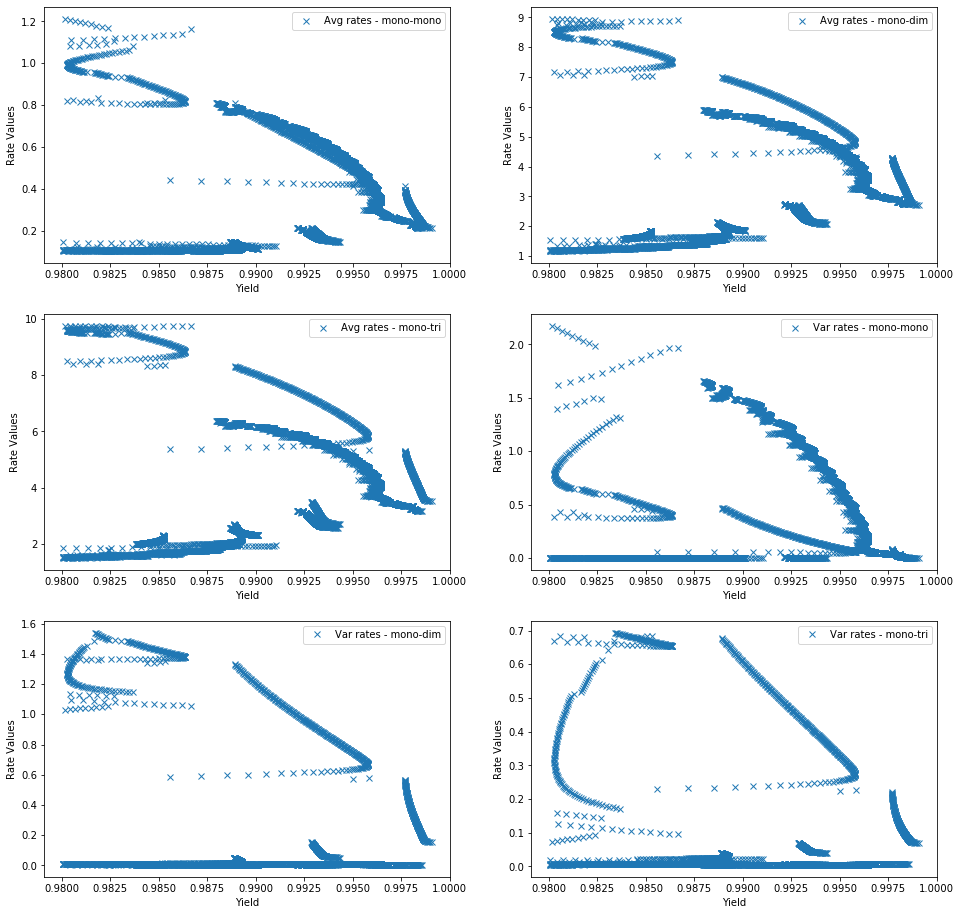

In [13]:
from matplotlib import pyplot as plt
n_features = len(asymm[0])
fig,ax = plt.subplots(int(n_features/2),2,figsize=(16,16))
# %matplotlib notebook

asymm = np.reshape(np.array(asymm),(len(sorted_yields),len(asymm[0])))
sorted_yields.reshape((sorted_yields.shape[0],1))

mask = (sorted_yields < 1.0) & (sorted_yields >0.98)

row=0
col=0
counter=0
for i in range(n_features):
    ax[row,col].plot(sorted_yields[mask],asymm[mask,i],marker='x',linestyle='',label=final_lb[i])
    ax[row,col].legend()
    ax[row,col].set_xlabel("Yield")
    ax[row,col].set_ylabel("Rate Values")
    
    counter+=1
    row = row+(col%2)
    col = counter%2
    
    

In [14]:
#Let's see what some clustering reveals
#Is there a trend with high yield

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_params(params,final_y,n_clust):
#     feat_mat = np.concatenate((params,final_y),axis=1)
    feat_mat = params
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feat_mat)
    
    kmeans = KMeans(n_clusters = n_clust, random_state=0).fit(X_scaled)
    clus_cen = kmeans.cluster_centers_ #Obtain centroids for all the clusters
    transform_mat = kmeans.transform(feat_mat) #This method calculates the distance of each point from each cluster
    labels = kmeans.labels_  #Labels which frame belongs to which cluster
    
    return(labels,clus_cen,transform_mat)

In [15]:
#Clustering
print(asymm.shape,sorted_yields.shape)
n_clust=8

var_feat_mat = asymm[mask][:,:]

labels,clus_cen,transform_mat = cluster_params(var_feat_mat,sorted_yields.reshape((sorted_yields.shape[0],1)),n_clust)


clr_input = ['skyblue','orange','green','red','purple','gold','brown','olive','crimson','peru','lightgreen','turquoise','cyan']

print(transform_mat.shape)


(9964, 6) (9964,)
(6157, 8)


(6157, 1)
(6157, 1)
(6157, 1)
(6157, 1)
(6157, 1)
(6157, 1)
(6157, 1)
Cluster:  0
Cluster Centroid:  [ 1.48448995  1.15827096  1.05135108  2.1643864  -0.32390997 -0.34056258]
Min distance:  0.035311 Params:  [0.480873, 0.109537, 2.949027, 0.107228, 0.100206, 5.071433, 5.383773, 0.105604, 5.131597, 5.31841, 5.081841, 5.679412, 5.336874, 5.202272, 5.281981, 5.584767, 5.150172, 5.148608, 5.152697, 5.152262, 5.75587, 5.708204]
Cluster:  1
Cluster Centroid:  [-0.45485553 -0.30906464 -0.29016175 -0.64129659 -0.20000876 -0.19443851]
Min distance:  0.085301 Params:  [0.195748, 0.195316, 0.143877, 0.195445, 0.144024, 2.476876, 2.348335, 0.143509, 2.476121, 2.346031, 2.346432, 3.054795, 1.776898, 1.774809, 1.774954, 2.54748, 2.476907, 2.348497, 2.346636, 2.346875, 3.052004, 3.052549]
Cluster:  2
Cluster Centroid:  [1.85232729 2.18915099 2.42810129 0.19842782 3.83240509 4.27385635]
Min distance:  0.031324 Params:  [1.089485, 1.102561, 0.153356, 1.114586, 0.156312, 7.485629, 6.30255, 0.160074, 7.4

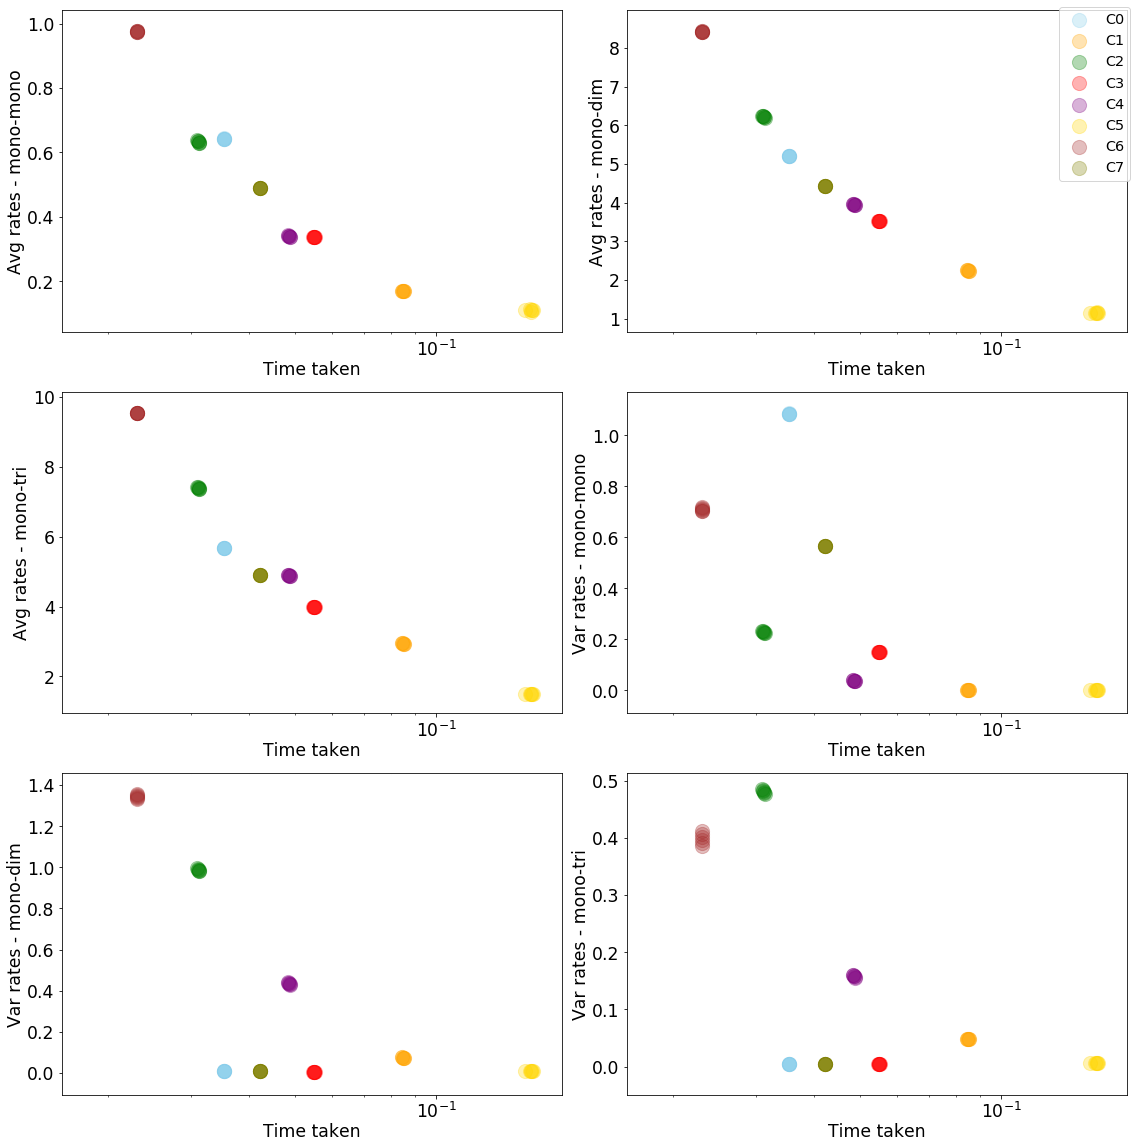

In [16]:
feat_rates =sorted_params[mask]
sel_t50 = sorted_t50[mask]
sel_t85 = sorted_t85[mask]
sel_t95 = sorted_t95[mask]

asymm_new = asymm[mask]

#Create a bianry matrix to know which elements are form a cluster
mask_01=(np.array(labels)==0)
cluster_mask = mask_01.reshape((len(labels),1))
for i in range(1,n_clust):
    n_arr = i*np.ones((len(labels),1))-np.array(labels).reshape(((len(labels),1)))
    mask_01=(n_arr==0)
    print(n_arr.shape)
    cluster_mask=np.hstack((cluster_mask,mask_01))

# cluster_mask = cluster_mask.astype(float)

fig,ax = plt.subplots(int(n_features/2),2,figsize=(16,16))
ax_hd = []

clust_min_solutions={}
for i in range(n_clust):
    
    clus_1_dist = transform_mat[cluster_mask[:,i],i]
    clus_1_par = feat_rates[cluster_mask[:,i],:]
    clus_1_t50 = sel_t50[cluster_mask[:,i]]
    clus_1_t85 = sel_t85[cluster_mask[:,i]]
    clus_1_t95 = sel_t95[cluster_mask[:,i]]
    clus_1_asymm = asymm_new[cluster_mask[:,i]]
    indx_sort = np.argsort(clus_1_dist)
    
    print("Cluster: ",i)
    print("Cluster Centroid: ",clus_cen[i])
    sorted_dist = clus_1_dist[indx_sort]
    sorted_par = clus_1_par[indx_sort]
    clus_sorted_t50 = clus_1_t50[indx_sort]
    clus_sorted_t85 = clus_1_t85[indx_sort]
    clus_sorted_t95 = clus_1_t95[indx_sort]
    clus_sorted_asymm = clus_1_asymm[indx_sort]
#     print("Max distance: ",sorted_dist[-1],"Params: ",sorted_par[-1])
    print("Min distance: ",clus_sorted_t85[0],"Params: ",list(sorted_par[0]))
    clust_min_solutions[i]=sorted_par[0]
    
    
    #Plotting
    row=0
    col=0
    counter=0
    for j in range(n_features):
        
#         h1=ax[row,col].scatter(clus_sorted_t85[-1],clus_sorted_asymm[-1,j],s=100,alpha=0.6,marker='o',color=clr_input[i], label='85%')
        h1 = ax[row,col].scatter(clus_sorted_t85[0:6],clus_sorted_asymm[0:6,j],s=200,alpha=0.3,marker='o',edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
        
        ax[row,col].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
        ax[row,col].set_ylabel(final_lb[j],fontdict={'fontsize':'xx-large'},labelpad=2.0)

        ax[row,col].set_xscale("log")
        ax[row,col].tick_params(labelsize='xx-large')
        
        if counter==0:
            ax_hd.append(h1)
        counter+=1
        row = row+(col%2)
        col = counter%2
fig.legend(ax_hd,['C0','C1','C2','C3','C4','C5','C6','C7'],fontsize='x-large')
fig.tight_layout()

/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Only MADD model
Only MADD model
Only MADD model
Only MADD model
Only MADD model
Only MADD model
Only MADD model
Only MADD model


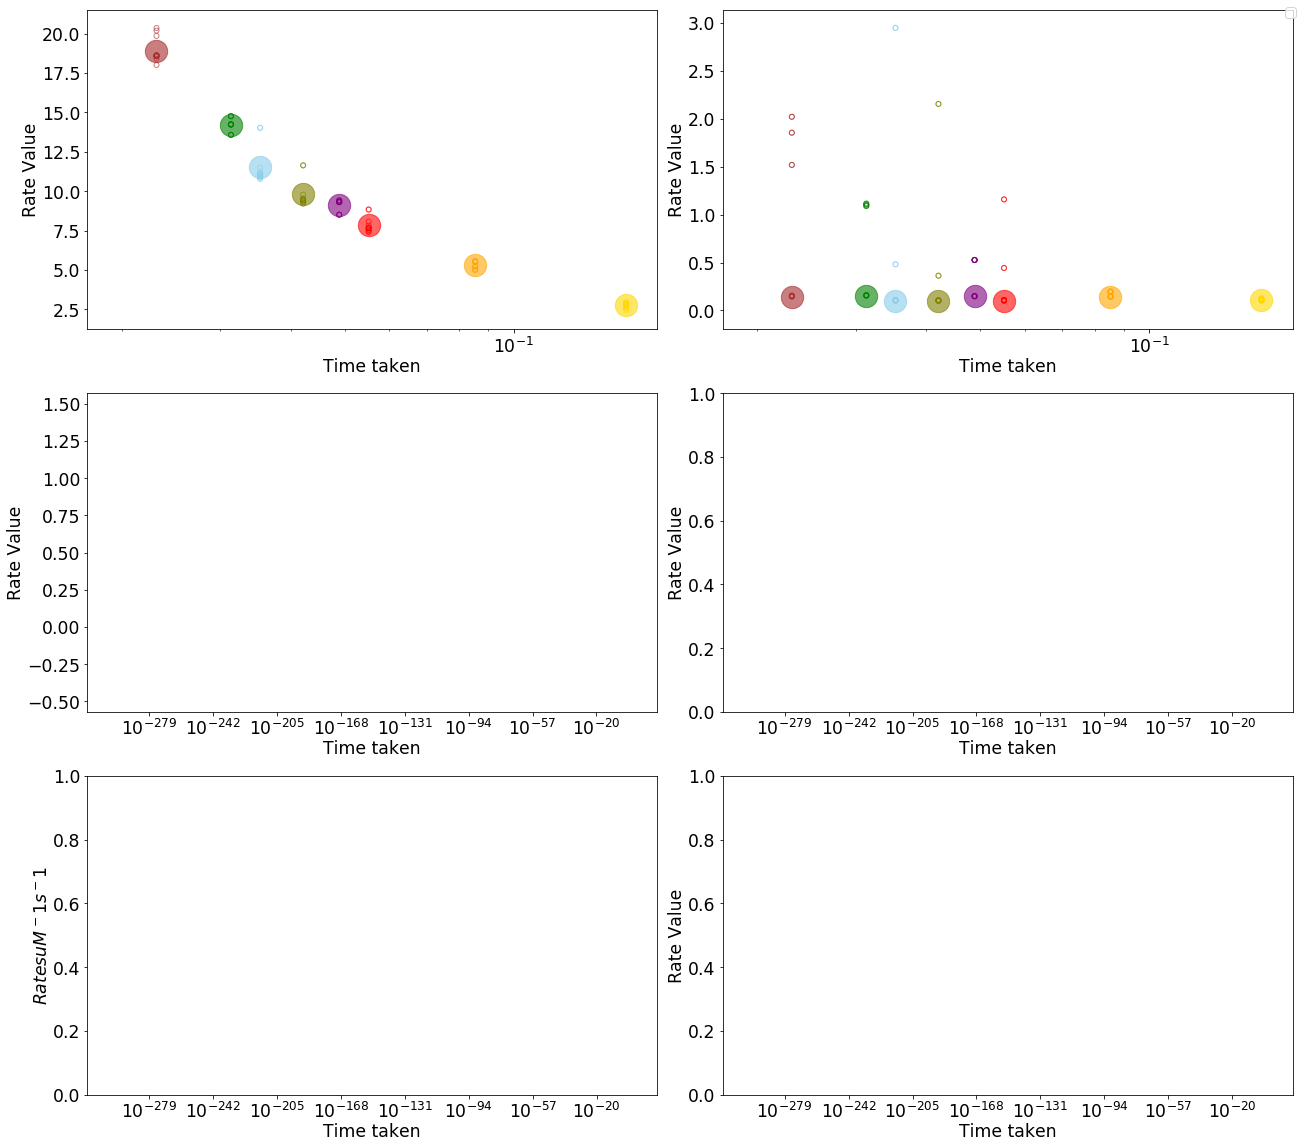

In [17]:
fig,ax = plt.subplots(3,2,figsize=(18,16))
ax_hd = []

clust_min_solutions={}

sel_total_madd_rates = total_madd_rates[mask]
sel_min_madd_rates = min_madd_rates[mask]
sel_total_dd_rates = total_dd_rates[mask]
sel_min_dd_rates = min_dd_rates[mask]

for i in range(n_clust):
    
    clus_1_dist = transform_mat[cluster_mask[:,i],i]
    clus_1_par = feat_rates[cluster_mask[:,i],:]
    clus_1_t50 = sel_t50[cluster_mask[:,i]]
    clus_1_t85 = sel_t85[cluster_mask[:,i]]
    clus_1_t95 = sel_t95[cluster_mask[:,i]]
    clus_1_asymm = asymm_new[cluster_mask[:,i]]
    indx_sort = np.argsort(clus_1_dist)
    
    clus_1_tot_madd_rates = sel_total_madd_rates[cluster_mask[:,i],:]
    clus_1_min_madd_rates = sel_min_madd_rates[cluster_mask[:,i],:]
    clus_1_tot_dd_rates = sel_total_dd_rates[cluster_mask[:,i],:]
    clus_1_min_dd_rates = sel_min_dd_rates[cluster_mask[:,i],:]
       
#     print("Cluster: ",i)
#     print("Cluster Centroid: ",clus_cen[i])
    sorted_dist = clus_1_dist[indx_sort]
    sorted_par = clus_1_par[indx_sort]
    clus_sorted_t50 = clus_1_t50[indx_sort]
    clus_sorted_t85 = clus_1_t85[indx_sort]
    clus_sorted_t95 = clus_1_t95[indx_sort]
    clus_sorted_asymm = clus_1_asymm[indx_sort]
    clust_min_solutions[i]=sorted_par[0]
    
    clus_sorted_tot_madd = clus_1_tot_madd_rates[indx_sort]
    clus_sorted_min_madd = clus_1_min_madd_rates[indx_sort]
    
    clus_sorted_tot_dd = clus_1_tot_dd_rates[indx_sort]
    clus_sorted_min_dd = clus_1_min_dd_rates[indx_sort]
    
      
    
    #Plotting
    row=0
    col=0
    counter=0
    for j in range(len(path_type['MADD'])):
        
#         h1=ax[row,col].scatter(clus_sorted_t85[-1],clus_sorted_asymm[-1,j],s=100,alpha=0.6,marker='o',color=clr_input[i], label='85%')
        h1 = ax[0,0].scatter(clus_sorted_t85[0],clus_sorted_tot_madd[0,j],s=100,alpha=0.6,marker='.',edgecolor=clr_input[i], facecolor='none', label='85%')
#         ax[0,0].boxplot(clus_sorted_t85[0],clus_sorted_tot_madd[0,j],s=200,alpha=0.6,marker='.',edgecolor=clr_input[i], facecolor='none', label='85%')
        
        ax[0,1].scatter(clus_sorted_t85[0],clus_sorted_min_madd[0,j],s=100,alpha=0.6,marker='.',edgecolor=clr_input[i], facecolor='none', label='85%')
    ax[0,0].scatter(clus_sorted_t85[0],np.mean(clus_sorted_tot_madd[0,:]),s=500,alpha=0.6,marker='o',edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
    ax[0,1].scatter(clus_sorted_t85[0],np.min(clus_sorted_min_madd[0,:]),s=500,alpha=0.6,marker='o',edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
    
    try:

        for j in range(len(path_type['DD'])):

            h1 = ax[1,0].scatter(clus_sorted_t85[0],clus_sorted_tot_dd[0,j],s=100,alpha=0.6,marker='.',edgecolor=clr_input[i], facecolor='none', label='85%')
            ax[1,1].scatter(clus_sorted_t85[0],clus_sorted_min_dd[0,j],s=100,alpha=0.6,marker='.',edgecolor=clr_input[i], facecolor='none', label='85%')
    #     print(len(clus_sorted_tot_dd[0,:]))
        ax[1,0].scatter(clus_sorted_t85[0],np.mean(clus_sorted_tot_dd[0,:]),s=500,alpha=0.6,marker='o',edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
        ax[1,1].scatter(clus_sorted_t85[0],np.min(clus_sorted_min_dd[0,:]),s=500,alpha=0.6,marker='o',edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
    except:
        print("Only MADD model")
ax[0,0].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[0,0].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[0,1].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[0,1].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[0,1].set_xscale("log")
ax[0,1].tick_params(labelsize='xx-large')
ax[0,0].set_xscale("log")
ax[0,0].tick_params(labelsize='xx-large')

ax[1,0].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[1,0].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[1,1].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[1,1].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[1,1].set_xscale("log")
ax[1,1].tick_params(labelsize='xx-large')
ax[1,0].set_xscale("log")
ax[1,0].tick_params(labelsize='xx-large')
# ax[1,0].set_ylim(bottom=0,top=50)

ax[2,0].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[2,0].set_ylabel(r"$Rates uM^-1 s^-1$",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[2,1].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[2,1].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[2,0].set_xscale("log")
ax[2,0].tick_params(labelsize='xx-large')
ax[2,1].set_xscale("log")
ax[2,1].tick_params(labelsize='xx-large')

fig.legend(ax_hd,['C0','C1','C2','C3','C4','C5','C6','C7'],fontsize='x-large')
fig.tight_layout()

Cluster:  0
Cluster Centroid:  [ 1.48448995  1.15827096  1.05135108  2.1643864  -0.32390997 -0.34056258]
Max distance:  7.191695435617934 Params:  [0.814389 0.108952 3.6279   0.104054 0.102107 5.75092  6.089396 0.103033
 5.832938 6.005243 5.746553 6.372976 6.049628 5.872319 5.954903 6.280801
 5.847121 5.8476   5.852467 5.835167 6.459982 6.401787]
Min distance:  6.316312212817942 Params:  [0.480873 0.109537 2.949027 0.107228 0.100206 5.071433 5.383773 0.105604
 5.131597 5.31841  5.081841 5.679412 5.336874 5.202272 5.281981 5.584767
 5.150172 5.148608 5.152697 5.152262 5.75587  5.708204]
Cluster:  1
Cluster Centroid:  [-0.45485553 -0.30906464 -0.29016175 -0.64129659 -0.20000876 -0.19443851]
Max distance:  6.783972515131355 Params:  [0.524024 0.523072 0.14974  0.523793 0.150914 4.696757 4.066703 0.147512
 4.691945 4.063166 4.065315 5.079738 2.886753 2.885777 2.885965 4.174364
 4.69573  4.067435 4.060604 4.062017 5.084412 5.082659]
Min distance:  4.214794662081657 Params:  [0.195748 0.1953

Text(40.5, 0.5, 'Variance of Monomer consumption')

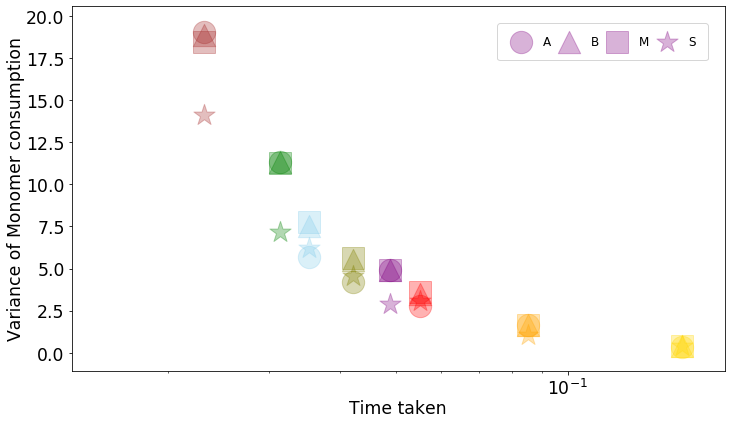

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax_hd = []

clust_min_solutions={}
clr_input = ['skyblue','orange','green','red','purple','gold','brown','olive','crimson','peru','lightgreen','turquoise','cyan']
for i in range(n_clust):
    
    clus_1_dist = transform_mat[cluster_mask[:,i],i]
    clus_1_par = feat_rates[cluster_mask[:,i],:]
    clus_1_t50 = sel_t50[cluster_mask[:,i]]
    clus_1_t85 = sel_t85[cluster_mask[:,i]]
    clus_1_t95 = sel_t95[cluster_mask[:,i]]
    clus_1_asymm = asymm_new[cluster_mask[:,i]]
    
    indx_sort = np.argsort(clus_1_dist)
    
    print("Cluster: ",i)
    print("Cluster Centroid: ",clus_cen[i])
    sorted_dist = clus_1_dist[indx_sort]
    sorted_par = clus_1_par[indx_sort]
    clus_sorted_t50 = clus_1_t50[indx_sort]
    clus_sorted_t85 = clus_1_t85[indx_sort]
    clus_sorted_t95 = clus_1_t95[indx_sort]
    clus_sorted_asymm = clus_1_asymm[indx_sort]
    print("Max distance: ",sorted_dist[-1],"Params: ",sorted_par[-1])
    print("Min distance: ",sorted_dist[0],"Params: ",sorted_par[0])
    clust_min_solutions[i]=sorted_par[0]
    
    
    #Plotting
    counter=0
    kcount=0
    marker_type = ['o','^','s','*']
    for k in monomer_rxns.keys():
        clus_1_mon = mon_consumption_var[k][mask][cluster_mask[:,i]]
        clus_sorted_mon_cons = clus_1_mon[indx_sort]
#         print(clus_1_mon.shape,clus_1_t85.shape)
#         h1=ax[row,col].scatter(clus_sorted_t85[-1],clus_sorted_asymm[-1,j],s=100,alpha=0.6,marker='o',color=clr_input[i], label='85%')
        h1 = ax.scatter(clus_sorted_t85[0],clus_sorted_mon_cons[0],s=500,alpha=0.3,marker=marker_type[kcount],edgecolor=clr_input[i], facecolor=clr_input[i], label='85%')
        
        ax.set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
#         ax.set_ylabel(final_lb[j],fontdict={'fontsize':'xx-large'},labelpad=2.0)

        ax.set_xscale("log")
        ax.tick_params(labelsize='xx-large')
        
        if counter<5 and i > 3:
            ax_hd.append(h1)
        counter+=1
        kcount+=1
                                                                                                                       
fig.legend(ax_hd,['A','B','M','S'],fontsize='large',ncol=5,columnspacing=0.5,loc ='upper right',borderaxespad=2.0,borderpad=1.0)
fig.tight_layout()
ax.set_ylabel("Variance of Monomer consumption",fontdict={'fontsize':'xx-large'},labelpad=1.0)

In [19]:
# for clust,rates in clust_min_solutions.items():
#     print("-------------------------")
#     print("-------------------------")
#     print("-----  Cluster  {:d}-----".format(clust))
    
for cl_id,lab in lb_rxn_class.items():
    
    print("------------------------------")
    print("------------------------------")
    print("------    {:s}    -------".format(lab))
    print("------------------------------")
    print("-------------------------------")
    print("%-12s\t%-4s\t%-4s\t%-4s\t%-4s\t%-4s\t%-4s\t%-4s\t%-4s\t%-4s\n" %('Reaction','uid','C0','C1','C2','C3','C4','C5','C6','C7'))
    for r_id in final_rxn_class[cl_id]:
        r1 = "".join(list(uid_reactants[r_id][0]))
        r2 = "".join(list(uid_reactants[r_id][1]))
        print("{:^4s} + {:^4s}".format(r1,r2),end='\t')
        print(r_id,end='\t')
        for clust,rates in clust_min_solutions.items():
            print("%-4.2f" %(rates[r_id]),end='\t')
        print("")
    

------------------------------
------------------------------
------    mono-mono    -------
------------------------------
-------------------------------
Reaction    	uid 	C0  	C1  	C2  	C3  	C4  	C5  	C6  	C7  

 M   +  A  	0	0.48	0.20	1.09	0.44	0.53	0.10	1.52	0.36	
 B   +  A  	1	0.11	0.20	1.10	0.11	0.53	0.10	1.85	0.10	
 S   +  A  	2	2.95	0.14	0.15	1.16	0.15	0.12	0.15	2.15	
 B   +  M  	3	0.11	0.20	1.11	0.11	0.53	0.11	2.02	0.11	
 S   +  M  	4	0.10	0.14	0.16	0.10	0.15	0.12	0.15	0.11	
 S   +  B  	7	0.11	0.14	0.16	0.11	0.15	0.12	0.15	0.10	
------------------------------
------------------------------
------    mono-dim    -------
------------------------------
-------------------------------
Reaction    	uid 	C0  	C1  	C2  	C3  	C4  	C5  	C6  	C7  

 BM  +  A  	16	5.15	2.48	7.48	3.44	4.71	0.98	9.91	4.36	
 MS  +  A  	17	5.15	2.35	6.31	3.46	4.07	1.06	8.51	4.36	
 BS  +  A  	18	5.15	2.35	6.31	3.47	4.07	1.06	8.50	4.36	
 BA  +  M  	5	5.07	2.48	7.49	3.46	4.71	1.11	9.90	4.31	
 SA  +  M  	6	5.38

KeyError: 4

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(8,10))

#MADD Pathway
for j in range(len(path_type['MADD'])):
    ax[0,0].scatter(sorted_t85[mask],total_madd_rates[mask,j],s=200,alpha=0.6,marker='o',edgecolor=clr_input[4], facecolor='none', label='85%')
    ax[0,1].scatter(sorted_t85[mask],min_madd_rates[mask,j],s=200,alpha=0.6,marker='o',edgecolor=clr_input[4], facecolor='none', label='85%')
ax[0,0].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[0,0].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[0,1].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[0,1].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[0,1].set_xscale("log")
ax[0,1].tick_params(labelsize='xx-large')
ax[0,0].set_xscale("log")
ax[0,0].tick_params(labelsize='xx-large')

#DD Pathway
for j in range(len(path_type['DD'])):
    ax[1,0].scatter(sorted_t85[mask],total_dd_rates[mask,j],s=200,alpha=0.6,marker='o',edgecolor=clr_input[5], facecolor='none', label='85%')
    ax[1,1].scatter(sorted_t85[mask],min_dd_rates[mask,j],s=200,alpha=0.6,marker='o',edgecolor=clr_input[5], facecolor='none', label='85%')
ax[1,0].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[1,0].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[1,1].set_xlabel("Time taken",fontdict={'fontsize':'xx-large'},labelpad=1.0)
ax[1,1].set_ylabel("Rate Value",fontdict={'fontsize':'xx-large'},labelpad=2.0)
ax[1,1].set_xscale("log")
ax[1,1].tick_params(labelsize='xx-large')
ax[1,0].set_xscale("log")
ax[1,0].tick_params(labelsize='xx-large')




plt.show()